# Project Overview and Objectives
The main purpose of this project was to build a CNN model that would classify if subject has a tumor or not based on MRI scan.We used some models architecture and weights to train the model for this binary problem. We used accuracy as a metric to justify the model performance which can be defined as:

Accuracy=(Number of correclty predicted imagesTotal)/(number of tested images)×100%

validation set - is the set used during the model training to adjust the hyperparameters.
test set - is the small set that We don't touch for the whole training process at all. It's been used for final model performance evaluation.

### why CNNs
i chose CNNs  for treir image analysis due to their ability to automatically extract meaningful features from input data, particularly images. Through convolution and pooling layers, CNNs can detect visual patterns such as edges, textures, and shapes without the need for manual feature engineering.

# What is Brain Tumor?

A brain tumor occurs when abnormal cells form within the brain. There are two main types of tumors: cancerous (malignant) tumors and benign tumors. Cancerous tumors can be divided into primary tumors, which start within the brain, and secondary tumors, which have spread from elsewhere, known as brain metastasis tumors. All types of brain tumors may produce symptoms that vary depending on the part of the brain involved. These symptoms may include headaches, seizures, problems with vision, vomiting and mental changes. The headache is classically worse in the morning and goes away with vomiting. Other symptoms may include difficulty walking, speaking or with sensations. As the disease progresses, unconsciousness may occur.

In [1]:
import numpy as np 
import pandas as pd 
import os 
from os import listdir 
import tensorflow as tf 
from keras.preprocessing.image import ImageDataGenerator 
import cv2
import matplotlib.pyplot as plt
%matplotlib inline
import imutils
from tensorflow.keras.models import Model,load_model
from tensorflow.keras.layers import Conv2D,Input,ZeroPadding2D,BatchNormalization,Flatten,Activation,Dense,MaxPooling2D
from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle #shuffling the data improves the model
from PIL import Image

# Data Import and Preprocessing

entrez le path du bureau de votre pc

In [2]:
bureau_path = r"C:\Users\idirm\OneDrive\Bureau"
print(bureau_path)

C:\Users\idirm\OneDrive\Bureau


In [3]:
image_dir= bureau_path

Making directory for augmented images.

A directory is formed using os.makedirs() function for augmented images(yes/ no). Note- custom directory is obtained in outputs folder.

In [4]:
import os

# Create directories if they don't exist
os.makedirs(image_dir + r'\augmented-images', exist_ok=True)
os.makedirs(image_dir + r'\augmented-images\yes', exist_ok=True)
os.makedirs(image_dir + r'\augmented-images\no', exist_ok=True)

# Define paths for yes and no directories
augmented_data_path = image_dir + r'\augmented-images'
augmented_yes = os.path.join(augmented_data_path, r'yes')
augmented_no = os.path.join(augmented_data_path, r'no')

# Set the image size
IMG_SIZE = (224, 224)

In [5]:
augmented_no

'C:\\Users\\idirm\\OneDrive\\Bureau\\augmented-images\\no'

# Augmentation of images
Data augmentation is a strategy that enables practitioners to significantly increase the diversity of data available for training models, without actually collecting new data.

Data augmentation techniques such as cropping, padding, and horizontal flipping are commonly used to train large neural networks.

About the data: The dataset contains 2 folders: yes and no which contains 253 Brain MRI Images. The folder yes contains 155 Brain MRI Images that are tumorous andno contains 98 Brain MRI Images that are non-tumorous. After applying augmentation we will have 2065 samples

In [6]:
def augment_data(file_dir, n_generated_samples, save_to_dir):
    data_gen = ImageDataGenerator(rotation_range=10, 
                                  width_shift_range=0.1, 
                                  height_shift_range=0.1, 
                                  shear_range=0.1, 
                                  brightness_range=(0.3, 1.0),
                                  horizontal_flip=True, 
                                  vertical_flip=True, 
                                  fill_mode='nearest'
                                 )

    for filename in listdir(file_dir):
        image = cv2.imread(file_dir + '/' + filename)
        # reshape the image
        image = image.reshape((1,)+image.shape)
        save_prefix = 'aug_' + filename[:-4]
        i=0
        for batch in data_gen.flow(x=image, batch_size=1, save_to_dir=save_to_dir,save_prefix=save_prefix, save_format='jpg'):
                i += 1
                if i > n_generated_samples:
                    break

In [7]:
dir = os.listdir(image_dir + r'\brain_tumor_dataset\yes') 

if len(dir) <= 200: 

    # augment data for the examples with label equal to 'yes' representing tumurous examples
    augment_data(file_dir=image_dir+ r'\brain_tumor_dataset\yes',n_generated_samples=6, save_to_dir=augmented_data_path+ r'\yes')
    # augment data for the examples with label equal to 'no' representing non-tumurous examples
    augment_data(file_dir=image_dir+ r'\brain_tumor_dataset\no', n_generated_samples=9, save_to_dir=augmented_data_path+ r'\no')
else:
    print(len(dir))

In [8]:
#essaie 2
def load_data(dir_list):
    X = []
    y = []

    for directory in dir_list:
        for filename in listdir(directory):
            image = cv2.imread(directory+'/'+filename)
            X.append(image)
            if directory[-3:] == 'yes':
                y.append(1)
            else:
                y.append(0)

    # No need to convert to NumPy array if you're using a list
    # X = np.array(X)
    y = np.array(y)

    # Shuffle the data
    X, y = shuffle(X, y)

    print(f'Number of examples is: {len(X)}')
    print(f'X length is: {len(X)}')
    print(f'y shape is: {y.shape}')

    return X, y

In [9]:
def split_data(X, y, test_size=0.2):
       
    X_train, X_test_val, y_train, y_test_val = train_test_split(X, y, test_size=test_size)
    X_test, X_val, y_test, y_val = train_test_split(X_test_val, y_test_val, test_size=0.5)
    
    return X_train, y_train, X_val, y_val, X_test, y_test

In [10]:
def plot_samples(X, y, labels_dict, n=50):
    """
    Creates a grid plot for the desired number of images (n) from the specified set
    """
    y_flat = np.squeeze(y.astype(int))  # Ensure y is a 1D array of integers
    for index in range(len(labels_dict)):
        indices = np.where(y_flat == index)[0][:n]  # Use np.where to get indices
        imgs = [X[i] for i in indices]
        j = 10
        i = int(n/j)

        plt.figure(figsize=(15, 6))
        c = 1
        for img in imgs:
            plt.subplot(i, j, c)
            plt.imshow(img)

            plt.xticks([])
            plt.yticks([])
            c += 1
        plt.suptitle('Tumor: {}'.format(labels_dict[index]))
        plt.show()


In [11]:
X_train, y_train = load_data([augmented_yes, augmented_no])

Number of examples is: 2063
X length is: 2063
y shape is: (2063,)


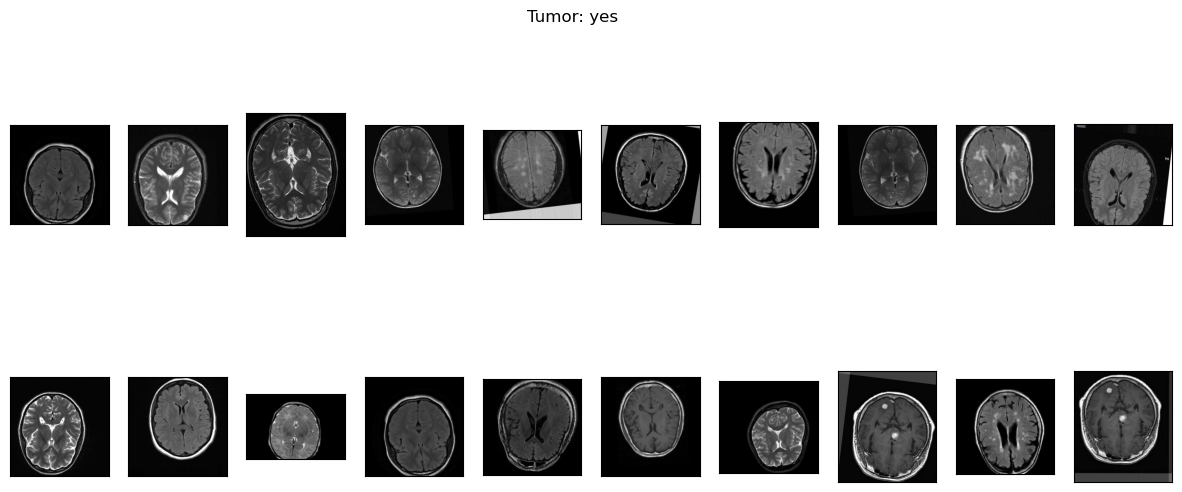

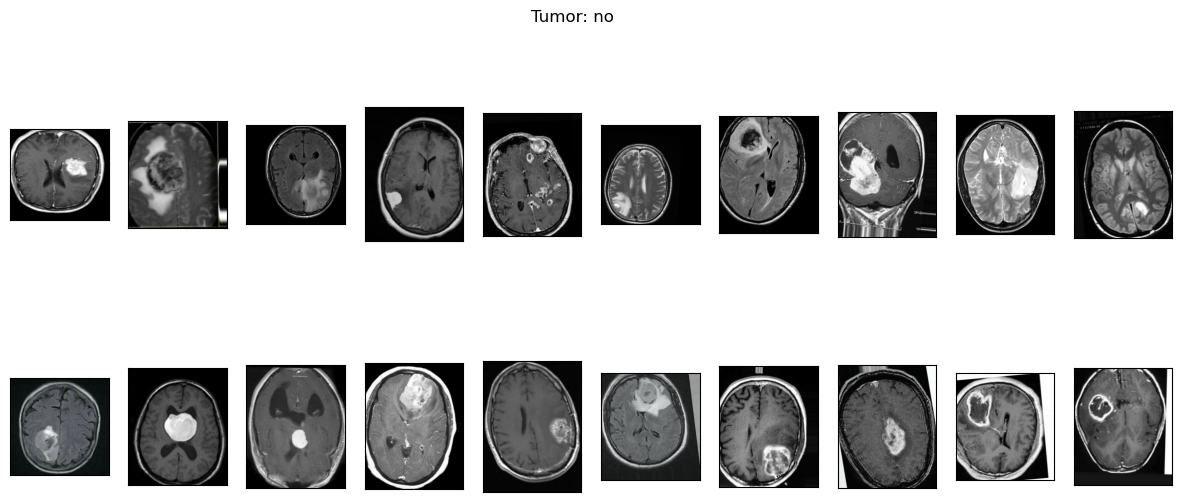

In [12]:
plot_samples(X_train, y_train, ['yes', 'no'], 20)

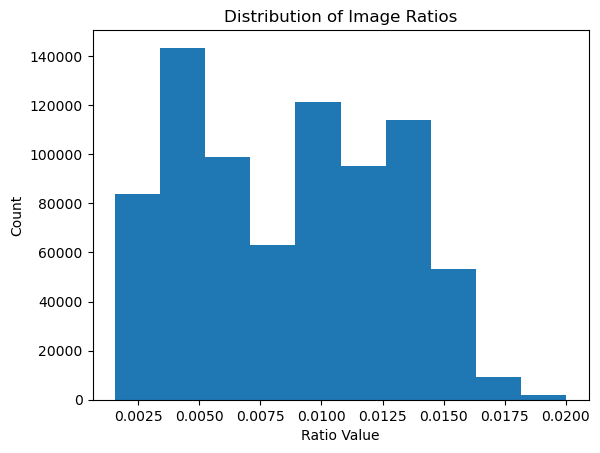

In [13]:
RATIO_LIST = []
for set in (X_train):
    for img in set:
        RATIO_LIST.append(img.shape[1]/img.shape[0])
        
plt.hist(RATIO_LIST)
plt.title('Distribution of Image Ratios')
plt.xlabel('Ratio Value')
plt.ylabel('Count')
plt.show()

In [14]:
del RATIO_LIST

## Preprocessing the data

In order to crop the specific part of the image containing tumour,cropping technique via OpenCv is used, the details can be found here.How to find extreme points in OpenCv?

#### After applying the cropping function

In [15]:
def crop_brain_contour(image, plot=False):
    
    # Convert the image to grayscale, and blur it slightly
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    gray = cv2.GaussianBlur(gray, (5, 5), 0)
    
    thresh = cv2.threshold(gray, 45, 255, cv2.THRESH_BINARY)[1]
    thresh = cv2.erode(thresh, None, iterations=2)
    thresh = cv2.dilate(thresh, None, iterations=2)

    # Find contours in thresholded image, then grab the largest one
    cnts = cv2.findContours(thresh.copy(), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    cnts = imutils.grab_contours(cnts)
    c = max(cnts, key=cv2.contourArea)
    # extreme points
    extLeft = tuple(c[c[:, :, 0].argmin()][0])
    extRight = tuple(c[c[:, :, 0].argmax()][0])
    extTop = tuple(c[c[:, :, 1].argmin()][0])
    extBot = tuple(c[c[:, :, 1].argmax()][0])
    
    # crop new image out of the original image using the four extreme points (left, right, top, bottom)
    new_image = image[extTop[1]:extBot[1], extLeft[0]:extRight[0]]            

    if plot:
        plt.figure()
        plt.subplot(1, 2, 1)
        plt.imshow(image)
        plt.tick_params(axis='both', which='both', top=False, bottom=False, left=False, right=False,labelbottom=False, labeltop=False, labelleft=False, labelright=False)
        plt.title('Original Image')
        plt.subplot(1, 2, 2)
        plt.imshow(new_image)
        plt.tick_params(axis='both', which='both',top=False, bottom=False, left=False, right=False,labelbottom=False, labeltop=False, labelleft=False, labelright=False)
        plt.title('Cropped Image')
        plt.show()
    
    return new_image

In [16]:
img = cv2.imread( image_dir + r'/brain_tumor_dataset/yes/Y108.jpg')
img = cv2.resize(
            img,
            dsize=IMG_SIZE,
            interpolation=cv2.INTER_CUBIC
        )
gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
gray = cv2.GaussianBlur(gray, (5, 5), 0)

# threshold the image, then perform a series of erosions +
# dilations to remove any small regions of noise
thresh = cv2.threshold(gray, 45, 255, cv2.THRESH_BINARY)[1]
thresh = cv2.erode(thresh, None, iterations=2)
thresh = cv2.dilate(thresh, None, iterations=2)

# find contours in thresholded image, then grab the largest one
cnts = cv2.findContours(thresh.copy(), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
cnts = imutils.grab_contours(cnts)
c = max(cnts, key=cv2.contourArea)

# find the extreme points
extLeft = tuple(c[c[:, :, 0].argmin()][0])
extRight = tuple(c[c[:, :, 0].argmax()][0])
extTop = tuple(c[c[:, :, 1].argmin()][0])
extBot = tuple(c[c[:, :, 1].argmax()][0])

# add contour on the image
img_cnt = cv2.drawContours(img.copy(), [c], -1, (0, 255, 255), 4)

# add extreme points
img_pnt = cv2.circle(img_cnt.copy(), extLeft, 8, (0, 0, 255), -1)
img_pnt = cv2.circle(img_pnt, extRight, 8, (0, 255, 0), -1)
img_pnt = cv2.circle(img_pnt, extTop, 8, (255, 0, 0), -1)
img_pnt = cv2.circle(img_pnt, extBot, 8, (255, 255, 0), -1)

# crop
ADD_PIXELS = 0
new_img = img[extTop[1]-ADD_PIXELS:extBot[1]+ADD_PIXELS, extLeft[0]-ADD_PIXELS:extRight[0]+ADD_PIXELS].copy()

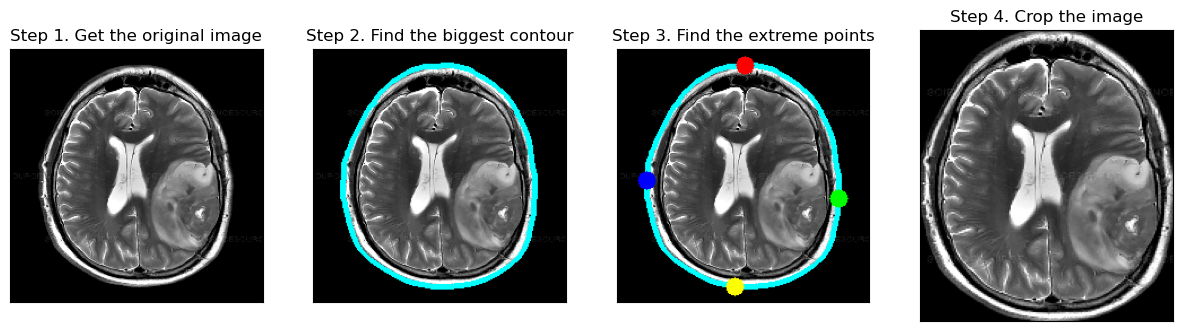

In [17]:
plt.figure(figsize=(15,6))
plt.subplot(141)
plt.imshow(img)
plt.xticks([])
plt.yticks([])
plt.title('Step 1. Get the original image')
plt.subplot(142)
plt.imshow(img_cnt)
plt.xticks([])
plt.yticks([])
plt.title('Step 2. Find the biggest contour')
plt.subplot(143)
plt.imshow(img_pnt)
plt.xticks([])
plt.yticks([])
plt.title('Step 3. Find the extreme points')
plt.subplot(144)
plt.imshow(new_img)
plt.xticks([])
plt.yticks([])
plt.title('Step 4. Crop the image')
plt.show()

## Locate the tumor manually <3
#hardcoding lol

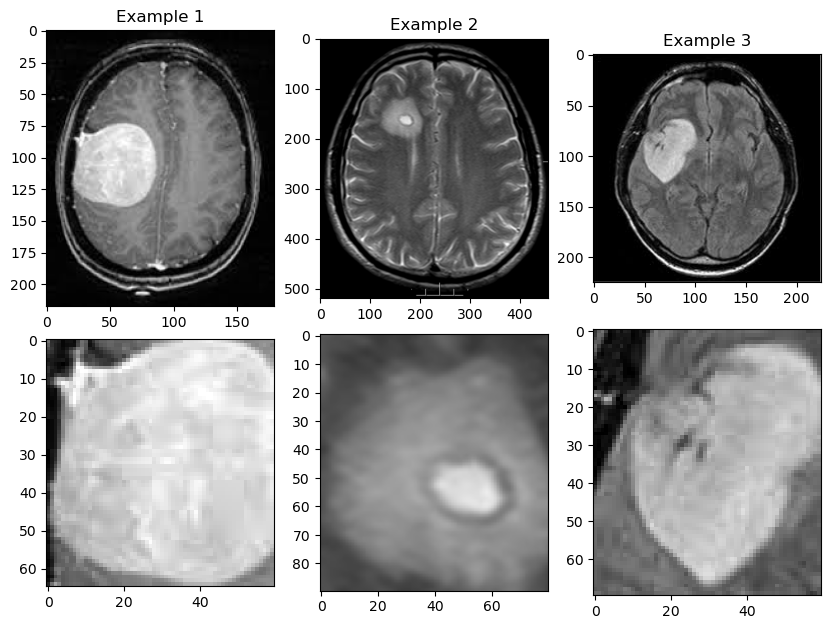

In [18]:
examples = [Image.open(image_dir + r'\brain_tumor_dataset\yes' + r'\Y1.jpg'),Image.open(image_dir + r'\brain_tumor_dataset\yes' + r'\Y3.jpg'),Image.open(image_dir + r'\brain_tumor_dataset\yes' + r'\Y4.jpg')]

# Spécifier les coordonnées de la région à extraire
x_start, y_start, x_end, y_end = 20, 75, 80, 140

## print some example images from train directory
fig = plt.figure(figsize=(10,14))

for i in range(0, len(examples)):
    a = fig.add_subplot(2, 3, i+1)
    imgplot = plt.imshow(examples[i])
    a.set_title('Example '+str(i+1))

# Extraire la région spécifiée
region_cropee = examples[0].crop((x_start, y_start, x_end, y_end))

# Afficher la région extraite
a = fig.add_subplot(1, 3, 1)
imgplot = plt.imshow(region_cropee) 

x_start, y_start, x_end, y_end = 120, 110, 200, 200
region_cropee = examples[1].crop((x_start, y_start, x_end, y_end))
a = fig.add_subplot(1, 3, 2)
imgplot = plt.imshow(region_cropee) 
x_start, y_start, x_end, y_end = 40, 60, 100, 130
region_cropee = examples[2].crop((x_start, y_start, x_end, y_end))
a = fig.add_subplot(1, 3, 3)
imgplot = plt.imshow(region_cropee) 

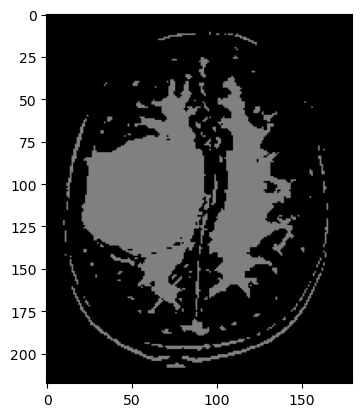

In [19]:
image = cv2.imread(image_dir + r'\brain_tumor_dataset\yes' + r'\Y1.jpg')
def change_quantization_step(image, quantization_step):

# Calculate the new pixel values.
    new_pixel_values = np.floor(image / quantization_step) * quantization_step

# Return the image with the new pixel values.
    return new_pixel_values.astype(np.uint8)
# Change the quantization step to 128.
imge = change_quantization_step(image, 128)
plt.figure()
plt.imshow(imge, cmap='gray')
plt.show()

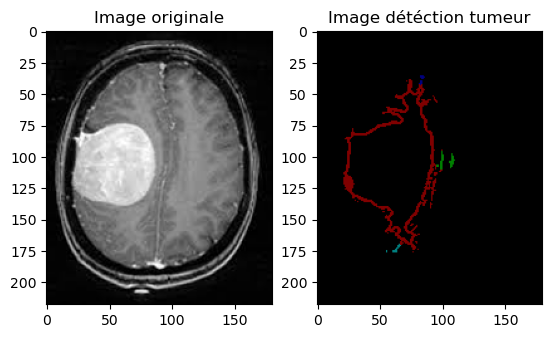

In [20]:
blurred = cv2.GaussianBlur(imge, (5, 5), 0)
# Utiliser la détection de contours de Canny
edges = cv2.Canny(blurred, 50, 150)
# Trouver les contours dans l'image
contours, _ = cv2.findContours(edges, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
# Trier les contours par aire (du plus grand au plus petit)
sorted_contours = sorted(contours, key=cv2.contourArea, reverse=True)

# Sélectionner le deuxième contour (si disponible)
if len(sorted_contours) > 1:
    second_largest_contour = sorted_contours[1]
    # find the extreme points
    extLeft_ = tuple(second_largest_contour[second_largest_contour[:, :, 0].argmin()][0])
    extRight_ = tuple(second_largest_contour[second_largest_contour[:, :, 0].argmax()][0])
    extTop_ = tuple(second_largest_contour[second_largest_contour[:, :, 1].argmin()][0])
    extBot_ = tuple(second_largest_contour[second_largest_contour[:, :, 1].argmax()][0])
    # Créer un masque pour le deuxième plus grand contour
    mask = np.zeros_like(imge)
    mask = cv2.drawContours(mask, [second_largest_contour], -1, (0, 0, 255),4)
    
    # add extreme points
    mask = cv2.circle(mask.copy(), extLeft_, 8, (0, 0, 255), -1)
    mask = cv2.circle(mask, extRight_, 8, (0, 255, 0), -1)
    mask = cv2.circle(mask, extTop_, 8, (255, 0, 0), -1)
    mask = cv2.circle(mask, extBot_, 8, (255, 255, 0), -1)
    # Recadrer l'image en fonction du deuxième plus grand contour
    cropped_image = cv2.bitwise_and(imge, mask)

    # Afficher l'image originale
    plt.subplot(1, 2, 1)
    plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
    plt.title('Image originale')

    # Afficher l'image recadrée selon le deuxième plus grand contour
    plt.subplot(1, 2, 2)
    plt.imshow(cv2.cvtColor(cropped_image, cv2.COLOR_BGR2RGB))
    plt.title('Image détéction tumeur')

    plt.show()
else:
    print("Il n'y a pas assez de contours pour extraire le deuxième plus grand.")


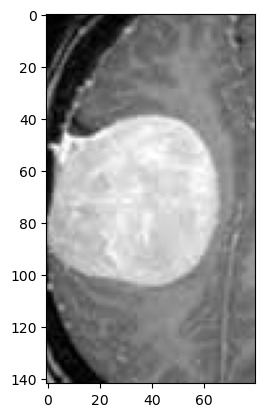

In [22]:
# Crop the image based on extreme points
new_image = image[extTop_[1]:extBot_[1], extLeft_[0]:extRight_[0]].copy()
plt.imshow(cv2.cvtColor(new_image, cv2.COLOR_BGR2RGB))

### croping the images

In [23]:
def crop_brain_contour(image, target_size=(224, 224), plot=False):
    # Your existing code for finding contours and extreme points
    
    # Crop the image based on extreme points
    new_image = image[extTop[1]:extBot[1], extLeft[0]:extRight[0]].copy()
    
    # Resize the cropped image using zooming
    new_image = cv2.resize(new_image, dsize=target_size, interpolation=cv2.INTER_CUBIC)

    return new_image
X_t = crop_brain_contour(X_train)

TypeError: list indices must be integers or slices, not tuple

In [24]:
def Croping_Data(train):
    # load all images in a directory
    X = []
    y = []

    for img in train:
        # Resize the image to a consistent size during cropping
        resized_img = cv2.resize(img, dsize=IMG_SIZE, interpolation=cv2.INTER_CUBIC)
        cropped_img = crop_brain_contour(resized_img, plot=False)
        
        # Print the dimensions of each cropped image
        print(f"Cropped image shape: {cropped_img.shape}")
        
        X.append(cropped_img)

    X = np.array(X)

    return X

In [25]:
X = Croping_Data(X_train)

Cropped image shape: (224, 224, 3)
Cropped image shape: (224, 224, 3)
Cropped image shape: (224, 224, 3)
Cropped image shape: (224, 224, 3)
Cropped image shape: (224, 224, 3)
Cropped image shape: (224, 224, 3)
Cropped image shape: (224, 224, 3)
Cropped image shape: (224, 224, 3)
Cropped image shape: (224, 224, 3)
Cropped image shape: (224, 224, 3)
Cropped image shape: (224, 224, 3)
Cropped image shape: (224, 224, 3)
Cropped image shape: (224, 224, 3)
Cropped image shape: (224, 224, 3)
Cropped image shape: (224, 224, 3)
Cropped image shape: (224, 224, 3)
Cropped image shape: (224, 224, 3)
Cropped image shape: (224, 224, 3)
Cropped image shape: (224, 224, 3)
Cropped image shape: (224, 224, 3)
Cropped image shape: (224, 224, 3)
Cropped image shape: (224, 224, 3)
Cropped image shape: (224, 224, 3)
Cropped image shape: (224, 224, 3)
Cropped image shape: (224, 224, 3)
Cropped image shape: (224, 224, 3)
Cropped image shape: (224, 224, 3)
Cropped image shape: (224, 224, 3)
Cropped image shape:

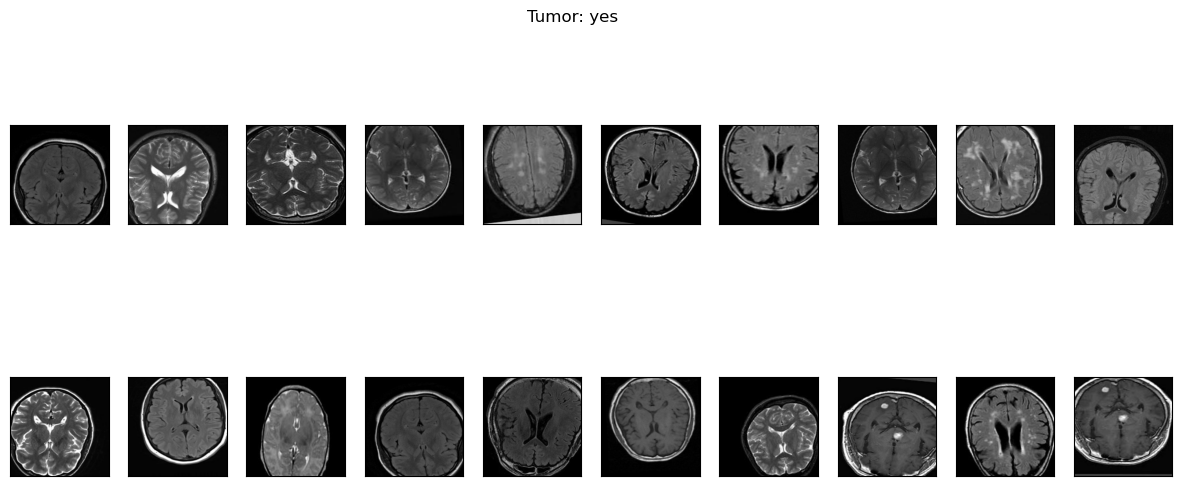

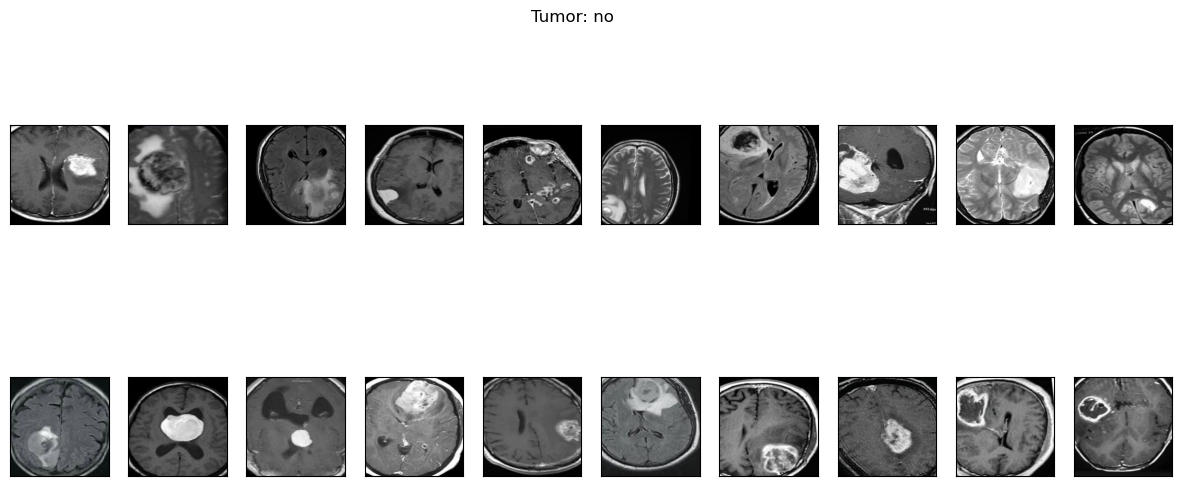

In [26]:
plot_samples(X, y_train, ['yes','no'], 20)

In [24]:
def Resize_Data(train):

    # load all images in a directory
    X = []
    y = []
    
    IMG_WIDTH, IMG_HEIGHT = (240, 240)
    
    for img in train:
        image = cv2.resize(img, dsize=(IMG_WIDTH, IMG_HEIGHT), interpolation=cv2.INTER_CUBIC)
        # normalize values
        image = image / 255.
        # convert image to numpy array and append it to X
        X.append(image)
                
    X = np.array(X)
    
    return X

In [25]:
augmented_yes =augmented_data_path+r'\yes'
augmented_no = augmented_data_path+'no'

IMG_WIDTH, IMG_HEIGHT = (240, 240)

X = Resize_Data(X)
y = y_train

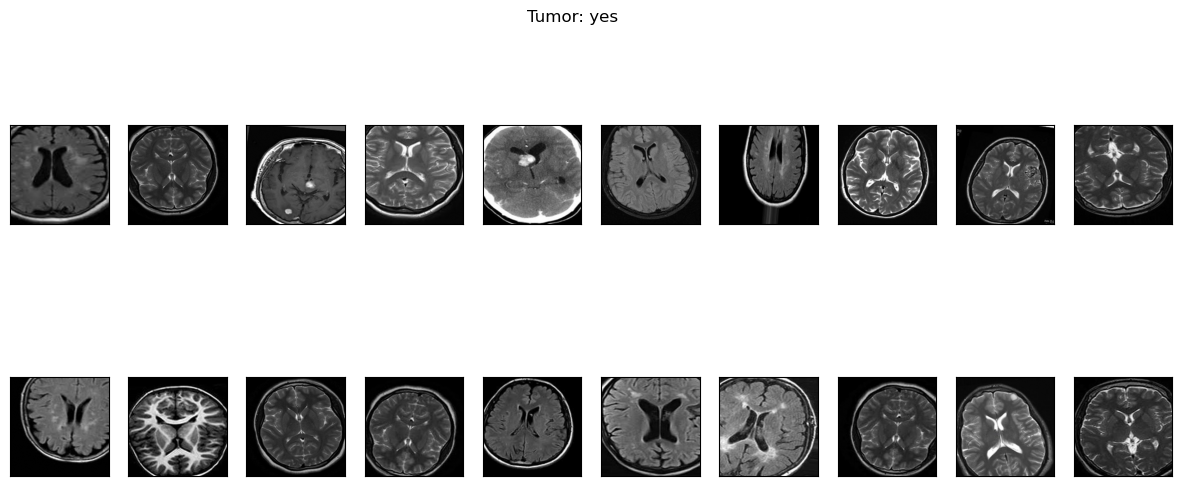

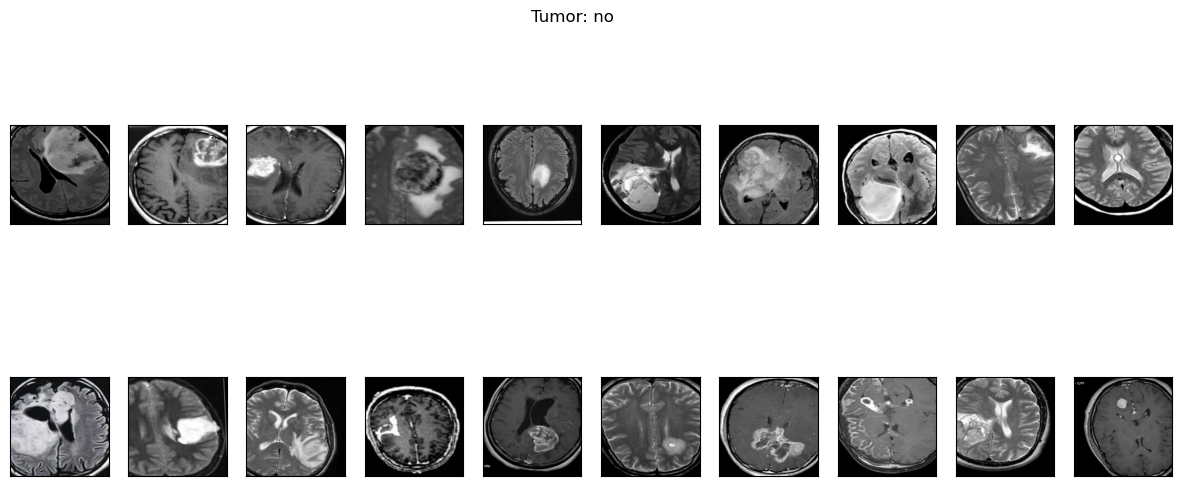

In [26]:
plot_samples(X, y_train, ['yes','no'],20)

In [27]:
img = cv2.imread(image_dir + r'\brain_tumor_dataset\no' + r'\1 no.jpeg')
img_arr = (np.round(np.array(img)*255)).astype(np.uint8)

# flatten
img_arr = img_arr.flatten()

yes_img = cv2.imread(image_dir + r'\brain_tumor_dataset\yes' + r'\Y1.jpg')
yes_img_arr = (np.round(np.array(yes_img)*255)).astype(np.uint8)

# flatten
yes_img_arr = yes_img_arr.flatten()

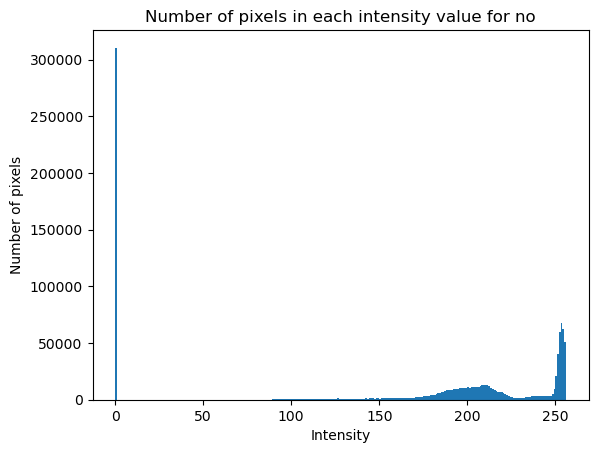

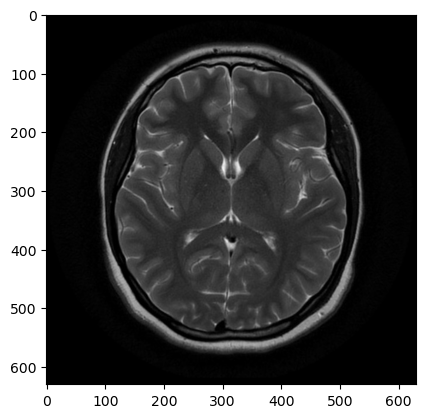

In [28]:
# plot histogram
plt.hist(img_arr, bins = 256, range = [0,256])
plt.title("Number of pixels in each intensity value for no")
plt.xlabel("Intensity")
plt.ylabel("Number of pixels")
plt.show()

plt.imshow(img)
plt.show()

Intensity of whitness is low which refelect that he don't have tumor.

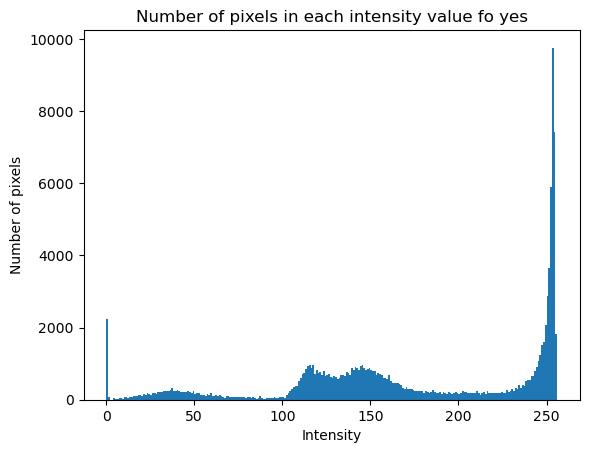

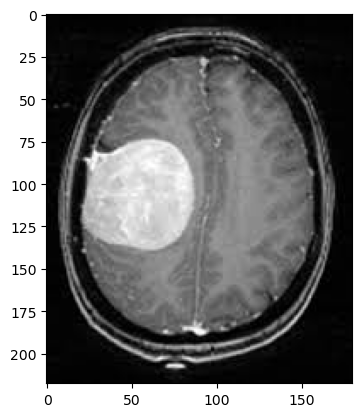

In [29]:
plt.hist(yes_img_arr, bins = 256, range = [0,256])
plt.title("Number of pixels in each intensity value fo yes")
plt.xlabel("Intensity")
plt.ylabel("Number of pixels")
plt.show()

plt.imshow(yes_img)
plt.show()

Intensity of whitness is very hight which refelect that he have brain tumor

In [30]:
del img 
del img_arr 


del yes_img 
del yes_img_arr 

# Visualization of data 

In [31]:
X_train, y_train, X_val, y_val, X_test, y_test = split_data(X, y, test_size=0.05)

In [32]:
del X 
del y

In [33]:
print ("number of training examples = " + str(X_train.shape[0]))
print ("number of validation examples = " + str(X_val.shape[0]))
print ("number of test examples = " + str(X_test.shape[0]))

number of training examples = 1960
number of validation examples = 52
number of test examples = 52


In [35]:
from plotly.offline import init_notebook_mode, iplot
import plotly.graph_objs as go

y = dict()
y[0] = []
y[1] = []
for set_name in (y_train, y_val, y_test):
    y[0].append(np.sum(set_name == 0))
    y[1].append(np.sum(set_name == 1))

trace0 = go.Bar(
    x=['Train Set', 'Validation Set', 'Test Set'],
    y=y[0],
    name='No',
    marker=dict(color='#33cc33'),
    opacity=0.7
)
trace1 = go.Bar(
    x=['Train Set', 'Validation Set', 'Test Set'],
    y=y[1],
    name='Yes',
    marker=dict(color='#ff3300'),
    opacity=0.7
)
data = [trace0, trace1]
layout = go.Layout(
    title='Count of classes in each set',
    xaxis={'title': 'Set'},
    yaxis={'title': 'Count'}
)
fig = go.Figure(data, layout)
iplot(fig)

# CNN Modeling
### Model building

In [ ]:
def build_model(input_shape):
    # Définition de l'entrée du modèle
    X_input = Input(input_shape)
    # Ajout de zéros autour de l'image (padding)
    X = ZeroPadding2D((2, 2))(X_input) 
    # Première couche de convolution avec 32 filtres, une taille de noyau de (7, 7) et pas de décalage
    X = Conv2D(32, (7, 7), strides=(1, 1))(X)
    # Normalisation par lots après la première couche de convolution
    X = BatchNormalization(axis=3, name='bn0')(X)
    # Activation ReLU
    X = Activation('relu')(X) 
    # Première couche de pooling (MaxPooling2D) avec une fenêtre de (4, 4)
    X = MaxPooling2D((4, 4))(X) 
    # Deuxième couche de pooling (MaxPooling2D) avec une fenêtre de (4, 4)
    X = MaxPooling2D((4, 4))(X) 
    # Aplatir les données en vue de les connecter à une couche dense
    X = Flatten()(X) 
    # Couche dense (fully connected) avec une seule sortie et une activation sigmoïde (binaire)
    X = Dense(1, activation='sigmoid')(X) 
    # Création du modèle en spécifiant les entrées et les sorties
    model = Model(inputs=X_input, outputs=X)
    return model

In [37]:
IMG_SHAPE = (IMG_WIDTH, IMG_HEIGHT, 3)
model=build_model(IMG_SHAPE)
model.summary()



Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 240, 240, 3)]     0         
                                                                 
 zero_padding2d (ZeroPaddin  (None, 244, 244, 3)       0         
 g2D)                                                            
                                                                 
 conv2d (Conv2D)             (None, 238, 238, 32)      4736      
                                                                 
 bn0 (BatchNormalization)    (None, 238, 238, 32)      128       
                                                                 
 activation (Activation)     (None, 238, 238, 32)      0         
                                                                 
 max_pooling2d (MaxPooling2  (None, 59, 59, 32)        0         
 D)                                                        

In [38]:
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
model.fit(x=X_train, y=y_train, batch_size=32, epochs=22, validation_data=(X_val, y_val)) #22


Epoch 1/22


62/62 [==============================] - 26s 412ms/step - loss: 0.7111 - accuracy: 0.6653 - val_loss: 0.5933 - val_accuracy: 0.7500
Epoch 2/22
62/62 [==============================] - 29s 466ms/step - loss: 0.5429 - accuracy: 0.7378 - val_loss: 0.5634 - val_accuracy: 0.8462
Epoch 3/22
62/62 [==============================] - 50s 802ms/step - loss: 0.4718 - accuracy: 0.7847 - val_loss: 0.5751 - val_accuracy: 0.5962
Epoch 4/22
62/62 [==============================] - 51s 821ms/step - loss: 0.4667 - accuracy: 0.7755 - val_loss: 0.5388 - val_accuracy: 0.7308
Epoch 5/22
62/62 [==============================] - 48s 781ms/step - loss: 0.4632 - accuracy: 0.7832 - val_loss: 0.5147 - val_accuracy: 0.7500
Epoch 6/22
62/62 [==============================] - 48s 771ms/step - loss: 0.4763 - accuracy: 0.7816 - val_loss: 0.4186 - val_accuracy: 0.8269
Epoch 7/22
62/62 [==============================] - 25s 406ms/step - loss: 0.3836 - accuracy: 0.8296 - val_loss: 0.4390 - val_accuracy: 0.8

Plotting of aaccuracy

In [39]:
history = model.history.history

In [40]:
def plot_metrics(history):
    
    train_loss = history['loss']
    val_loss = history['val_loss']
    train_acc = history['accuracy']
    val_acc = history['val_accuracy']
    
    # Loss
    plt.figure()
    plt.plot(train_loss, label='Training Loss')
    plt.plot(val_loss, label='Validation Loss')
    plt.title('Loss')
    plt.legend()
    plt.show()
    
    # Accuracy
    plt.figure()
    plt.plot(train_acc, label='Training Accuracy')
    plt.plot(val_acc, label='Validation Accuracy')
    plt.title('Accuracy')
    plt.legend()
    plt.show()

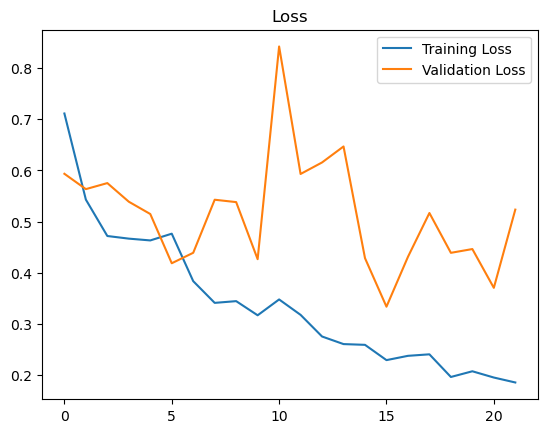

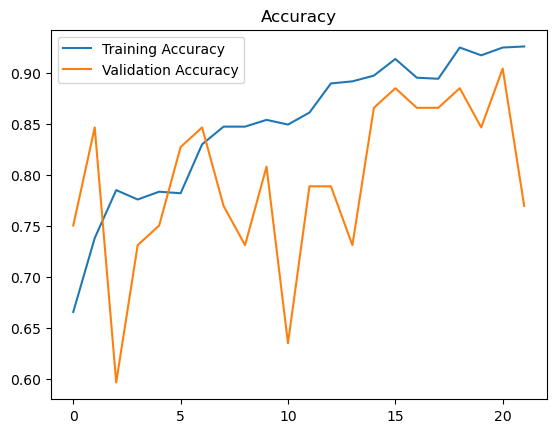

In [41]:
plot_metrics(history)

In [42]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.figure(figsize = (6,6))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=90)
    plt.yticks(tick_marks, classes)
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    thresh = cm.max() / 2.
    cm = np.round(cm,2)
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.show()

2/2 [==============================] - 2s 273ms/step
Val Accuracy = 0.77


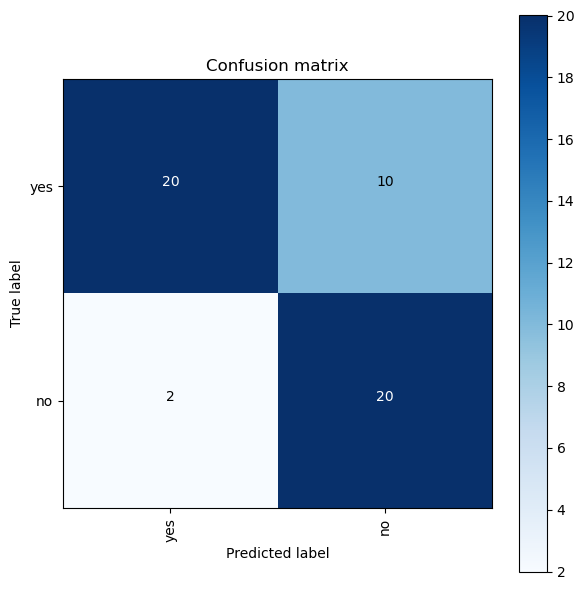

In [43]:
import itertools
from sklearn.metrics import accuracy_score, confusion_matrix
labels = ['yes','no']
# validate on val set
predictions = model.predict(X_val)
predictions = [1 if x>0.5 else 0 for x in predictions]

accuracy = accuracy_score(y_val, predictions)
print('Val Accuracy = %.2f' % accuracy)

confusion_mtx = confusion_matrix(y_val, predictions) 
cm = plot_confusion_matrix(confusion_mtx, classes = labels, normalize=False)

2/2 [==============================] - 1s 438ms/step
Test Accuracy = 0.75


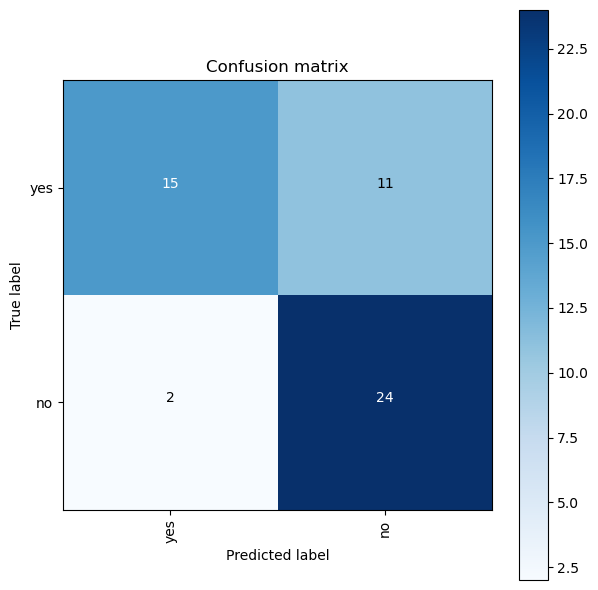

In [44]:
# validate on test set
predictions = model.predict(X_test)
predictions = [1 if x>0.5 else 0 for x in predictions]

accuracy = accuracy_score(y_test, predictions)
print('Test Accuracy = %.2f' % accuracy)

confusion_mtx = confusion_matrix(y_test, predictions) 
cm = plot_confusion_matrix(confusion_mtx, classes = labels, normalize=False)

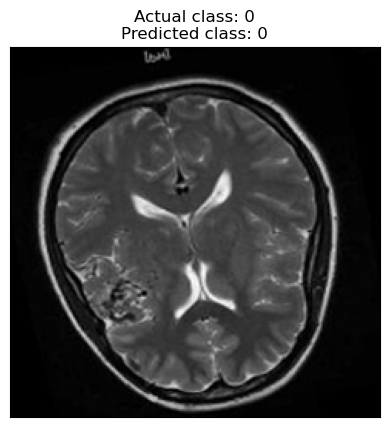

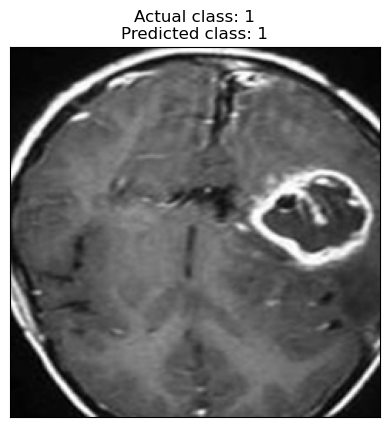

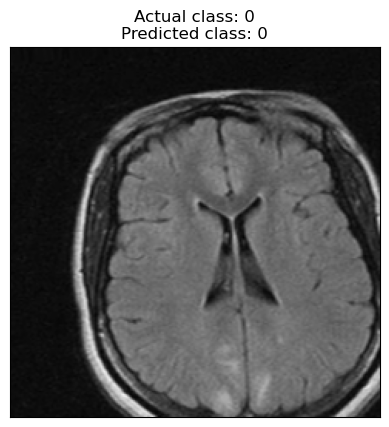

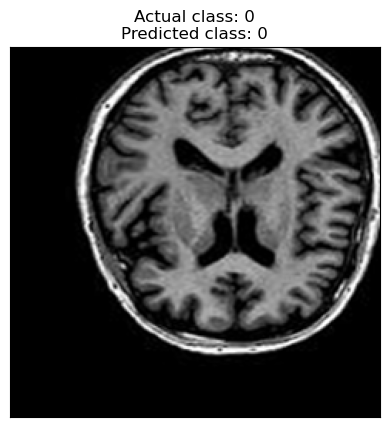

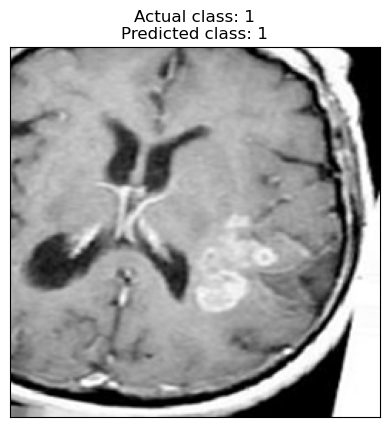

In [45]:
for i in range(5):
    plt.figure()
    plt.imshow(X_test[i])
    plt.xticks([])
    plt.yticks([])
    plt.title(f'Actual class: {y_test[i]}\nPredicted class: {predictions[i]}')
    plt.show()

In [46]:
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
model.fit(x=X_train, y=y_train, batch_size=32, epochs=44, validation_data=(X_val, y_val)) #44

Epoch 1/44
62/62 [==============================] - 22s 329ms/step - loss: 0.2273 - accuracy: 0.9066 - val_loss: 0.4404 - val_accuracy: 0.9038
Epoch 2/44
62/62 [==============================] - 24s 391ms/step - loss: 0.1691 - accuracy: 0.9316 - val_loss: 0.6090 - val_accuracy: 0.8269
Epoch 3/44
62/62 [==============================] - 32s 507ms/step - loss: 0.1641 - accuracy: 0.9332 - val_loss: 0.3386 - val_accuracy: 0.9038
Epoch 4/44
62/62 [==============================] - 24s 385ms/step - loss: 0.1589 - accuracy: 0.9429 - val_loss: 0.5258 - val_accuracy: 0.8269
Epoch 5/44
62/62 [==============================] - 47s 759ms/step - loss: 0.1499 - accuracy: 0.9485 - val_loss: 0.4051 - val_accuracy: 0.8654
Epoch 6/44
62/62 [==============================] - 70s 1s/step - loss: 0.1502 - accuracy: 0.9408 - val_loss: 0.6504 - val_accuracy: 0.8269
Epoch 7/44
62/62 [==============================] - 65s 1s/step - loss: 0.1694 - accuracy: 0.9316 - val_loss: 1.0811 - val_accuracy: 0.6346
Epoch

#### Too many epochs might cause overfitting!

Following is an intuitive explanation.

Any data = Behavior Pattern + Noise

Our objective is to find the pattern using Deep Learning model in the form of weights and biases for various nodes.

The objective of the DL model is to minimum error or maximum accuracy. In the process of minimizing error, it would have learnt the pattern but the error would not reach a absolute zero. If the training is continued for more epochs, model tries to reach zero error where it is starting to learn the noise of training data.

This noise can change from data sample to sample and hence you would observe the following curves when number of epochs is plotted against accuracy / error for training vs validation sets.

Yes. Accuracy would drop marginally but our objective was NOT to be good only on training data. Hence generalization / regularization is required for the model. Early Stopping is one technique that can help.

2/2 [==============================] - 0s 68ms/step
Val Accuracy = 0.83


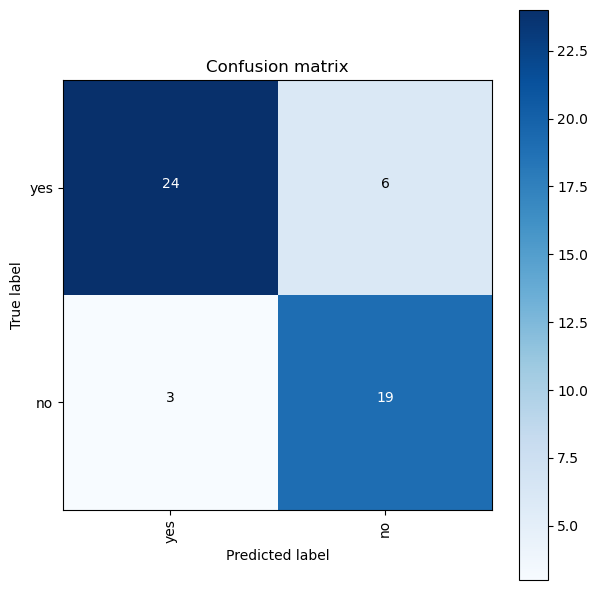

In [47]:
# validate on val set
predictions = model.predict(X_val)
predictions = [1 if x>0.5 else 0 for x in predictions]

accuracy = accuracy_score(y_val, predictions)
print('Val Accuracy = %.2f' % accuracy)

confusion_mtx = confusion_matrix(y_val, predictions) 
cm = plot_confusion_matrix(confusion_mtx, classes = labels, normalize=False)

2/2 [==============================] - 0s 69ms/step
Test Accuracy = 0.79


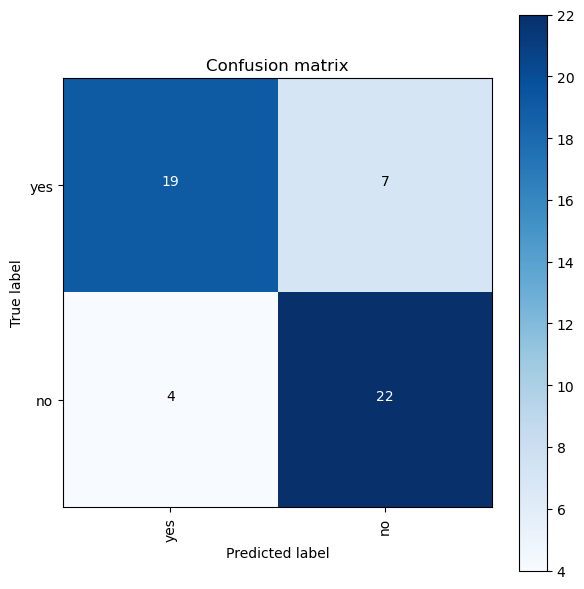

In [48]:
# validate on val set
predictions = model.predict(X_test)
predictions = [1 if x>0.5 else 0 for x in predictions]

accuracy = accuracy_score(y_test, predictions)
print('Test Accuracy = %.2f' % accuracy)

confusion_mtx = confusion_matrix(y_test, predictions) 
cm = plot_confusion_matrix(confusion_mtx, classes = labels, normalize=False)

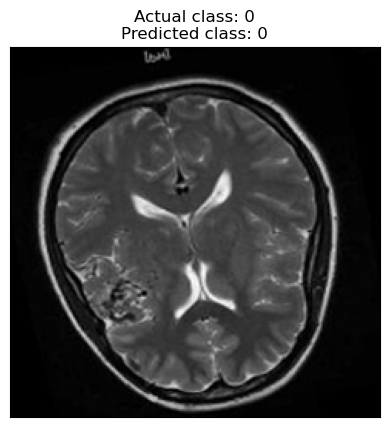

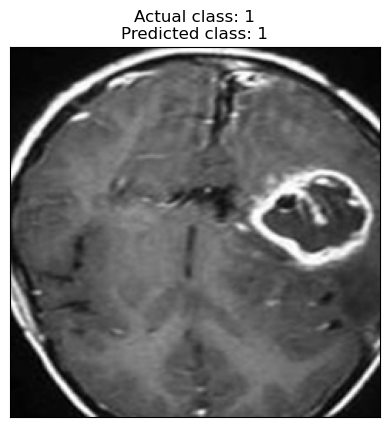

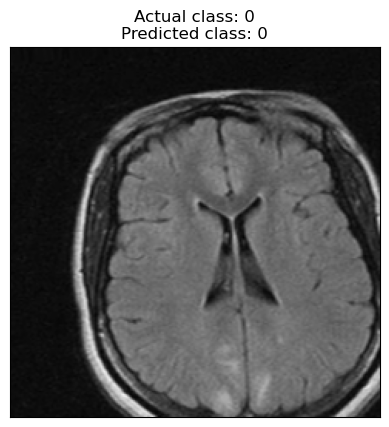

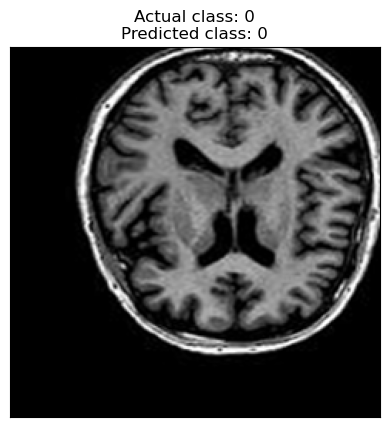

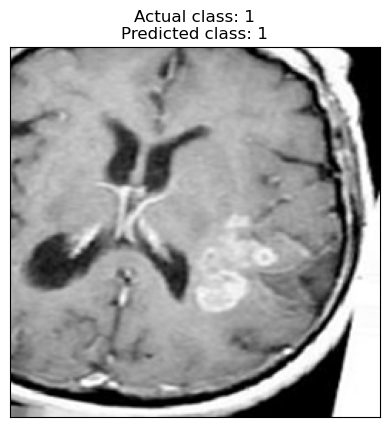

In [49]:
for i in range(5):
    plt.figure()
    plt.imshow(X_test[i])
    plt.xticks([])
    plt.yticks([])
    plt.title(f'Actual class: {y_test[i]}\nPredicted class: {predictions[i]}')
    plt.show()

# 6. Conclusions
This project was a combination of CNN model classification problem (to predict wheter the subject has brain tumor or not) & Computer Vision problem (to automate the process of brain cropping from MRI scans). The final accuracy is about 99%.